In [77]:
import sys
sys.path.append('../')

import os
import SimpleITK as sitk
import numpy as np
from utils.dataset import display_two_volumes, display_volumes

In [5]:
subject = 'copd1'
reference_image_path = os.path.join(os.getcwd(),f'../dataset/train/{subject}/{subject}_eBHCT.nii.gz') # _lung

In [6]:
reference_image_path

'c:\\Users\\abdal\\Documents\\Master\\EMJMD MAIA\\SEMESTER 3 - UdG\\MIRA\\COPDgene-CT-registration\\notebooks\\../dataset/train/copd1/copd1_eBHCT.nii.gz'

In [44]:
copd1_eBHCT = sitk.ReadImage(reference_image_path)

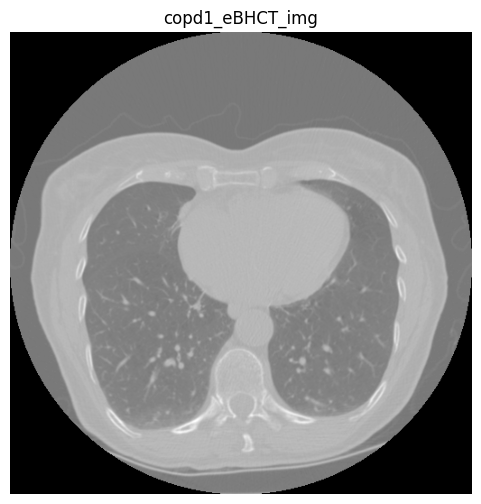

In [45]:
copd1_eBHCT_img = sitk.GetArrayFromImage(copd1_eBHCT)
display_volumes(copd1_eBHCT_img, title1='copd1_eBHCT_img', slice1 = 80)

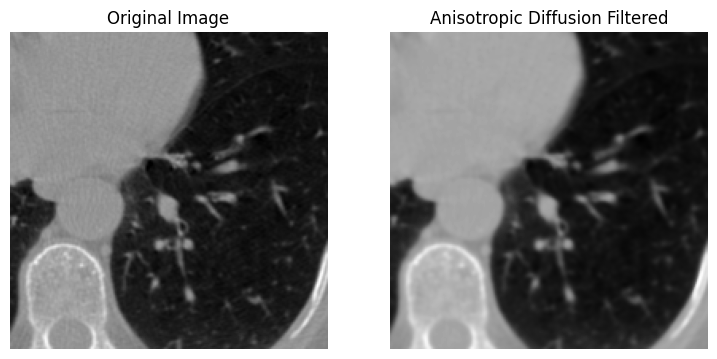

In [97]:
def anisotropic_diffusion_denoise_3d(input_volume, conductance_parameter, time_step, number_of_iterations):
    # Convert the input volume to float
    input_volume_float = sitk.Cast(input_volume, sitk.sitkFloat32)

    anisotropic_diffusion = sitk.GradientAnisotropicDiffusionImageFilter()
    anisotropic_diffusion.SetConductanceParameter(conductance_parameter)
    anisotropic_diffusion.SetTimeStep(time_step)
    anisotropic_diffusion.SetNumberOfIterations(number_of_iterations)

    output_volume_float = anisotropic_diffusion.Execute(input_volume_float)
    output_volume = sitk.Cast(output_volume_float, sitk.sitkInt16)

    return output_volume

conductance_parameter = 3.0 
time_step = 0.0625 
number_of_iterations = 5 

output_image = anisotropic_diffusion_denoise_3d(copd1_eBHCT, conductance_parameter, time_step, number_of_iterations)
output_anisotropic_image = sitk.GetArrayFromImage(output_image)

# display_two_volumes(output_anisotropic_image, title1='output_anisotropic_image', slice1 = 70)
display_two_volumes(copd1_eBHCT_img[:, 220:420, 220:420], output_anisotropic_image[:, 220:420, 220:420], 'Original Image', 'Anisotropic Diffusion Filtered', slice=70)
# display_two_volumes(copd1_eBHCT_img[:, :, :], output_anisotropic_image[:, :, :], 'Original Image', 'anisotropic_diffusion Filtered', slice=70)

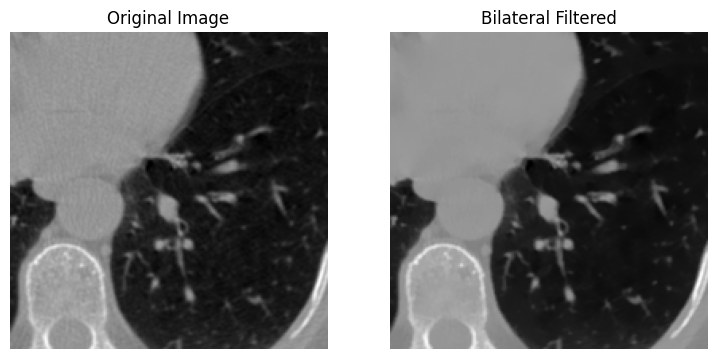

In [98]:
def bilateral_filter_3d(input_volume, domain_sigma, range_sigma):
    filtered_slices = []

    for z in range(input_volume.GetDepth()):
        # Get 2D slice
        input_slice = sitk.Extract(input_volume, (input_volume.GetWidth(), input_volume.GetHeight(), 1), (0, 0, z))

        # Apply bilateral filter to the 2D slice
        bilateral_filter = sitk.BilateralImageFilter()
        bilateral_filter.SetDomainSigma(domain_sigma)
        bilateral_filter.SetRangeSigma(range_sigma)
        output_slice = bilateral_filter.Execute(input_slice)

        # Append the filtered slice to the list
        filtered_slices.append(sitk.GetArrayFromImage(output_slice)[0]) # [0] to get the slice from the 3D volume

    # Convert the list of slices to a NumPy array
    filtered_slices_array = np.array(filtered_slices)
    output_volume = sitk.GetImageFromArray(filtered_slices_array)

    # Copy the information from the input volume to the output volume
    output_volume.CopyInformation(input_volume)

    return output_volume

domain_sigma = 2.0 
range_sigma = 50.0 

output_image = bilateral_filter_3d(copd1_eBHCT, domain_sigma, range_sigma)
output_bilateral_filter_image = sitk.GetArrayFromImage(output_image)

display_two_volumes(copd1_eBHCT_img[:, 220:420, 220:420], output_bilateral_filter_image[:, 220:420, 220:420], 'Original Image', 'Bilateral Filtered', slice=70)